# Project 1 - Supervised Learning <br>
## Nicole Cosmany <br>
Dataset: [Breast Cancer Gene Expression Profiles (METABRIC)](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric)


This dataset is sourced from Kaggle and includes clinical attributes, m-RNA levels z-score, and genes mutations for 1904 breast cancer patients. Breast cancer impacts 2.1 million women each year and accurate estimations of prognosis and survival are critical for the treatment and quality of life of these patients. 

My objectives: 
- explore data set
- compare use of different classification models to predict survival based on the clinical attributes

I will follow these general steps:
- EDA (look at distributions and correlations, identify target feature)
- cleaning (convert feature types as needed, drop redundant information, impute, normalize)
- model exploration + PCA
- discuss model performance
- discuss most important features
- summary and conclusion

# Part 1 - Cleaning & EDA


First, let's import the data and look through some basic attributes. 

In [315]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split


In [316]:
#import and view first few rows
data = pd.read_csv("METABRIC_RNA_Mutation.csv")
str(data)
data.head(5)

C:\Users\Nicole\AppData\Local\Temp\ipykernel_18988\1989273298.py:2: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


Based on the documentation on Kaggle, we expect this dataset to contain information for 1904 breast cancer patients. There should be just under 700 rows corresponding to 31 clinical attributes, m-RNA levels z-score for 331 genes, and mutation in 175 genes. Let's check the shape below to make sure everything looks as expected. 


In [317]:
#print rows and columns
rows, cols = data.shape
print("Columns =", cols)
print("Rows=", rows)

Columns = 693
Rows= 1904


In [318]:
#make sure all patient IDs are unique, should equal 1904
len(data["patient_id"].unique())

1904

Let's take a look at the attributes. The first 31 columns correspond to clinical attributes. 

In [319]:
#clinical attributes
clinical_attributes = data.iloc[:, 0:31].columns.to_list()
clinical_attributes

['patient_id',
 'age_at_diagnosis',
 'type_of_breast_surgery',
 'cancer_type',
 'cancer_type_detailed',
 'cellularity',
 'chemotherapy',
 'pam50_+_claudin-low_subtype',
 'cohort',
 'er_status_measured_by_ihc',
 'er_status',
 'neoplasm_histologic_grade',
 'her2_status_measured_by_snp6',
 'her2_status',
 'tumor_other_histologic_subtype',
 'hormone_therapy',
 'inferred_menopausal_state',
 'integrative_cluster',
 'primary_tumor_laterality',
 'lymph_nodes_examined_positive',
 'mutation_count',
 'nottingham_prognostic_index',
 'oncotree_code',
 'overall_survival_months',
 'overall_survival',
 'pr_status',
 'radio_therapy',
 '3-gene_classifier_subtype',
 'tumor_size',
 'tumor_stage',
 'death_from_cancer']

Now that we have a basic understanding of what's in this data set. Let's see if there are any changes we need to make before going further. Based on reading the documentation on Kaggle, there a few columns that present redundant information. Before making a decision on whether or not to remove columns, let's look for missing values. 

In [320]:
#check which columns have missing values and how many 
missingCols = data.columns[data.isna().any()].to_list()
missingInfo = pd.DataFrame(index = missingCols)
missingInfo["Count"] = data[missingCols].isnull().sum()
missingInfo

,Count
type_of_breast_surgery,22
cancer_type_detailed,15
cellularity,54
er_status_measured_by_ihc,30
neoplasm_histologic_grade,72
tumor_other_histologic_subtype,15
primary_tumor_laterality,106
mutation_count,45
oncotree_code,15
3-gene_classifier_subtype,204


Some things that stand out from above:<br>
- about 1/4 of all entries are missing tumor_stage <br>
- 204 entries missing 3-gene_classifier_subtype 
- all other missing values are low enough to not be concerning

I read through the Kaggle page to learn more about this dataset and found that both these columns present redundant information. Tumor_stage is a factor in calculating the nottingnottingham_prognostic_index. And the 3-gene_classifier_sbutype takes information about HER2 and ER status, both of which are included in other columns. Based on this information, I feel comfortable removing these columns from the dataset. 


In [321]:
#remove tumor_stage
data.drop("tumor_stage", axis=1, inplace=True)
data.drop("3-gene_classifier_subtype", axis =1, inplace= True)

In [322]:
#check shape is as anticipated 1904 rows and 691 columns 
data.shape

(1904, 691)

Now, we have the goal to classify survival.The survival metric has multiple columns which could serve as the target. Let's look into them a little more and decide which to use. 

Columns describing survival:
- death_from_cancer: yes/no did the patient die from cancer-related causes
- overall_survival: yes/no did the patient die
- overall_survival_months: months from diagnosis to death 

I am going to use **death_from_cancer** as the target variable because I think that makes the most sense given the context of the data set. It includes a label for people who died from other causes. Since there's about 400 people who died from other causes, I am going to eliminate overall_survival as an option this since this doesn't have that info. And survival months would not make for a clean classification problem. 

While we are looking into redundant information, let's examine columns describing cancer type:

- cancer_type: a more general classification for 1) Breast Cancer or 2) Breast Sarcoma
- cancer_type_detailed: includes more detailed types: 1- Breast Invasive Ductal Carcinoma 2- Breast Mixed Ductal and Lobular Carcinoma 3- Breast Invasive Lobular Carcinoma 4- Breast Invasive Mixed Mucinous Carcinoma 5- Metaplastic Breast Cancer
- oncotree_code: "The OncoTree is an open-source ontology that was developed at Memorial Sloan Kettering Cancer Center (MSK) for standardizing cancer type diagnosis from a clinical perspective by assigning each diagnosis a unique OncoTree code."
- tumor_other_histologic_subtype: Type of the cancer based on microscopic examination of the cancer tissue (It takes a value of 'Ductal/NST', 'Mixed', 'Lobular', 'Tubular/ cribriform', 'Mucinous', 'Medullary', 'Other', 'Metaplastic' )

I voted out using cancer_type because it is a binary category and doesn't have as much information. The next decision was between oncotree_code, cancer_type_detailed, and tumor_other_histologic_subtype. I look into the values for each of these below and see that the first represent identical information and the third is nearly identical. Based on these finds, I am going to choose **cancer_type_detailed** as the variable to keep just for the sake of readability.

In [323]:
print(data["oncotree_code"].value_counts())
print()
print(data["cancer_type_detailed"].value_counts())
print()
print(data["tumor_other_histologic_subtype"].value_counts())
print()
print(data["death_from_cancer"].value_counts())

oncotree_code
IDC       1500
MDLC       207
ILC        142
IMMC        22
BREAST      17
MBC          1
Name: count, dtype: int64

cancer_type_detailed
Breast Invasive Ductal Carcinoma             1500
Breast Mixed Ductal and Lobular Carcinoma     207
Breast Invasive Lobular Carcinoma             142
Breast Invasive Mixed Mucinous Carcinoma       22
Breast                                         17
Metaplastic Breast Cancer                       1
Name: count, dtype: int64

tumor_other_histologic_subtype
Ductal/NST             1454
Mixed                   207
Lobular                 142
Medullary                25
Mucinous                 22
Tubular/ cribriform      21
Other                    17
Metaplastic               1
Name: count, dtype: int64

death_from_cancer
Living                  801
Died of Disease         622
Died of Other Causes    480
Name: count, dtype: int64


In [324]:
#going to do some column removal based on redundant info explained above 
data.drop("oncotree_code", axis =1, inplace=True)
data.drop("cancer_type", axis=1, inplace= True)
data.drop("overall_survival", axis =1, inplace = True)
data.drop("er_status", axis=1, inplace=True)

In [325]:
#isolate clinical data as its own dataframe
clinical_data = data.iloc[:, 0:25]

#remove patients who died from other causes
clinical_data = clinical_data[clinical_data["death_from_cancer"]!="Died of Other Causes"]


In [326]:
obj_list = clinical_data.select_dtypes(include="object")
obj_list = obj_list.columns.to_list()
for obj in obj_list:
    print(clinical_data[obj].value_counts())


type_of_breast_surgery
MASTECTOMY           806
BREAST CONSERVING    602
Name: count, dtype: int64
cancer_type_detailed
Breast Invasive Ductal Carcinoma             1137
Breast Mixed Ductal and Lobular Carcinoma     141
Breast Invasive Lobular Carcinoma             104
Breast Invasive Mixed Mucinous Carcinoma       17
Breast                                         15
Name: count, dtype: int64
cellularity
High        706
Moderate    525
Low         151
Name: count, dtype: int64
pam50_+_claudin-low_subtype
LumA           462
LumB           339
Her2           172
Basal          169
claudin-low    166
Normal         112
NC               4
Name: count, dtype: int64
er_status_measured_by_ihc
Positve     1035
Negative     369
Name: count, dtype: int64
her2_status_measured_by_snp6
NEUTRAL    1006
GAIN        333
LOSS         82
UNDEF         3
Name: count, dtype: int64
her2_status
Negative    1219
Positive     205
Name: count, dtype: int64
tumor_other_histologic_subtype
Ductal/NST             

In [327]:
#get columns into the right data types
clinical_data["cancer_type_detailed"] = clinical_data["cancer_type_detailed"].astype("string")
clinical_data["cellularity"] = clinical_data["cellularity"].astype("string")
clinical_data["pam50_+_claudin-low_subtype"] = clinical_data["pam50_+_claudin-low_subtype"].astype("string")
clinical_data["er_status_measured_by_ihc"] = clinical_data["er_status_measured_by_ihc"].apply(lambda x: 1 if x=="Positive" else 0).astype("bool")
clinical_data["her2_status_measured_by_snp6"] = clinical_data["her2_status_measured_by_snp6"].astype("string")
clinical_data["her2_status"] = clinical_data["her2_status"].apply(lambda x: 1 if x == "Positive" else 0).astype("bool")
clinical_data["tumor_other_histologic_subtype"] = clinical_data["tumor_other_histologic_subtype"].astype("string")
clinical_data["inferred_menopausal_state"] = clinical_data["inferred_menopausal_state"].apply(lambda x: 1 if x == "Post" else 0).astype("bool")
clinical_data["integrative_cluster"] = clinical_data["integrative_cluster"].astype("string")
clinical_data["primary_tumor_laterality"] = clinical_data["primary_tumor_laterality"].astype("string")
clinical_data["pr_status"] = clinical_data["pr_status"].apply(lambda x: 1 if x == "Positive" else 0).astype("bool")
clinical_data["death_from_cancer"]= clinical_data["death_from_cancer"].apply(lambda x: 1 if x=="Died of Disease" else 0)
clinical_data["type_of_breast_surgery"] = clinical_data["type_of_breast_surgery"].astype("string")

#make 0/1s into bools
clinical_data["chemotherapy"] = clinical_data["chemotherapy"].astype("bool")
clinical_data["hormone_therapy"] = clinical_data["hormone_therapy"].astype("bool")
clinical_data["radio_therapy"] = clinical_data["radio_therapy"].astype("bool")


In [328]:
#look for top correlations 
categoricals = ["cancer_type_detailed", "type_of_breast_surgery","cellularity", "pam50_+_claudin-low_subtype", "her2_status_measured_by_snp6", "tumor_other_histologic_subtype", "integrative_cluster","primary_tumor_laterality" ]
clinical_data_encoded = pd.get_dummies(clinical_data, columns=categoricals)

corr = clinical_data_encoded.corr()
print("Correlations to living \n", corr.loc["death_from_cancer"].sort_values(ascending=False).head(5))

Correlations to living 
 death_from_cancer                    1.000000
nottingham_prognostic_index          0.273962
lymph_nodes_examined_positive        0.258938
tumor_size                           0.211455
type_of_breast_surgery_MASTECTOMY    0.185518
Name: death_from_cancer, dtype: float64


Text(0.5, 0.98, 'Distributions for Various Clinical Attributes')

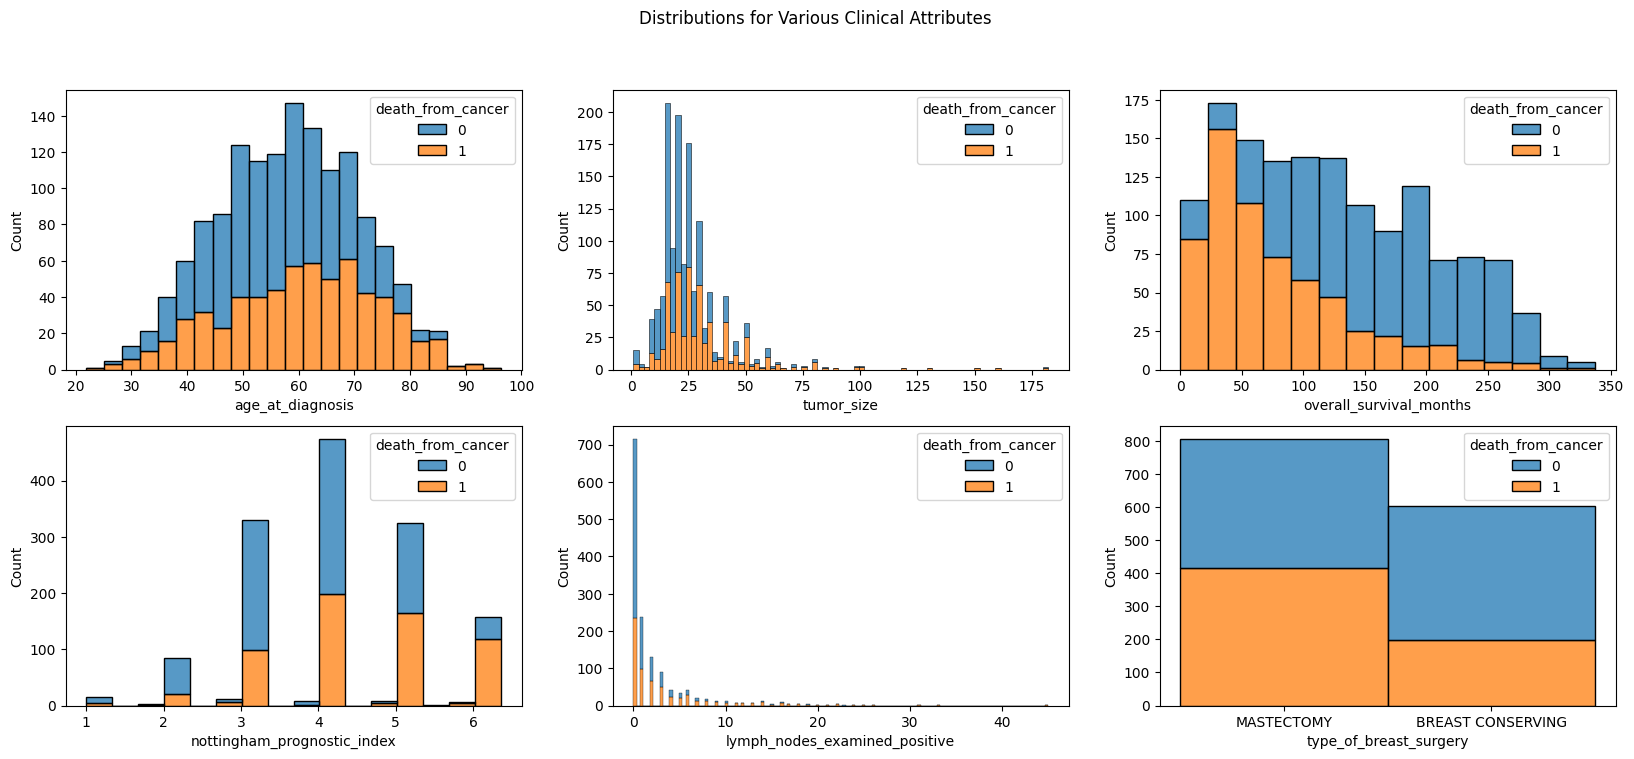

In [329]:
#let's look at some distributions now of some of these top correlated variables

fig, axes = plt.subplots(2, 3, figsize=(20, 8))
sns.histplot(data = clinical_data, x ="age_at_diagnosis", hue = "death_from_cancer", ax = axes[0,0], multiple ="stack")
sns.histplot(data = clinical_data, x = "tumor_size", hue = "death_from_cancer", ax = axes[0,1], multiple="stack")
sns.histplot(data = clinical_data, x = "overall_survival_months", hue = "death_from_cancer", ax = axes[0,2], multiple = "stack")
sns.histplot(data = clinical_data, x = "nottingham_prognostic_index", hue = "death_from_cancer", ax = axes[1,0], multiple = "stack")
sns.histplot(data = clinical_data, x = "lymph_nodes_examined_positive", hue = "death_from_cancer", ax = axes[1,1], multiple = "stack")
sns.histplot(data = clinical_data, x = "type_of_breast_surgery", hue = "death_from_cancer", ax = axes[1,2], multiple = "stack")
fig.suptitle("Distributions for Various Clinical Attributes")

Text(0.5, 0.98, 'Distributions of Gene Expressions for Randomly Chosen Genes')

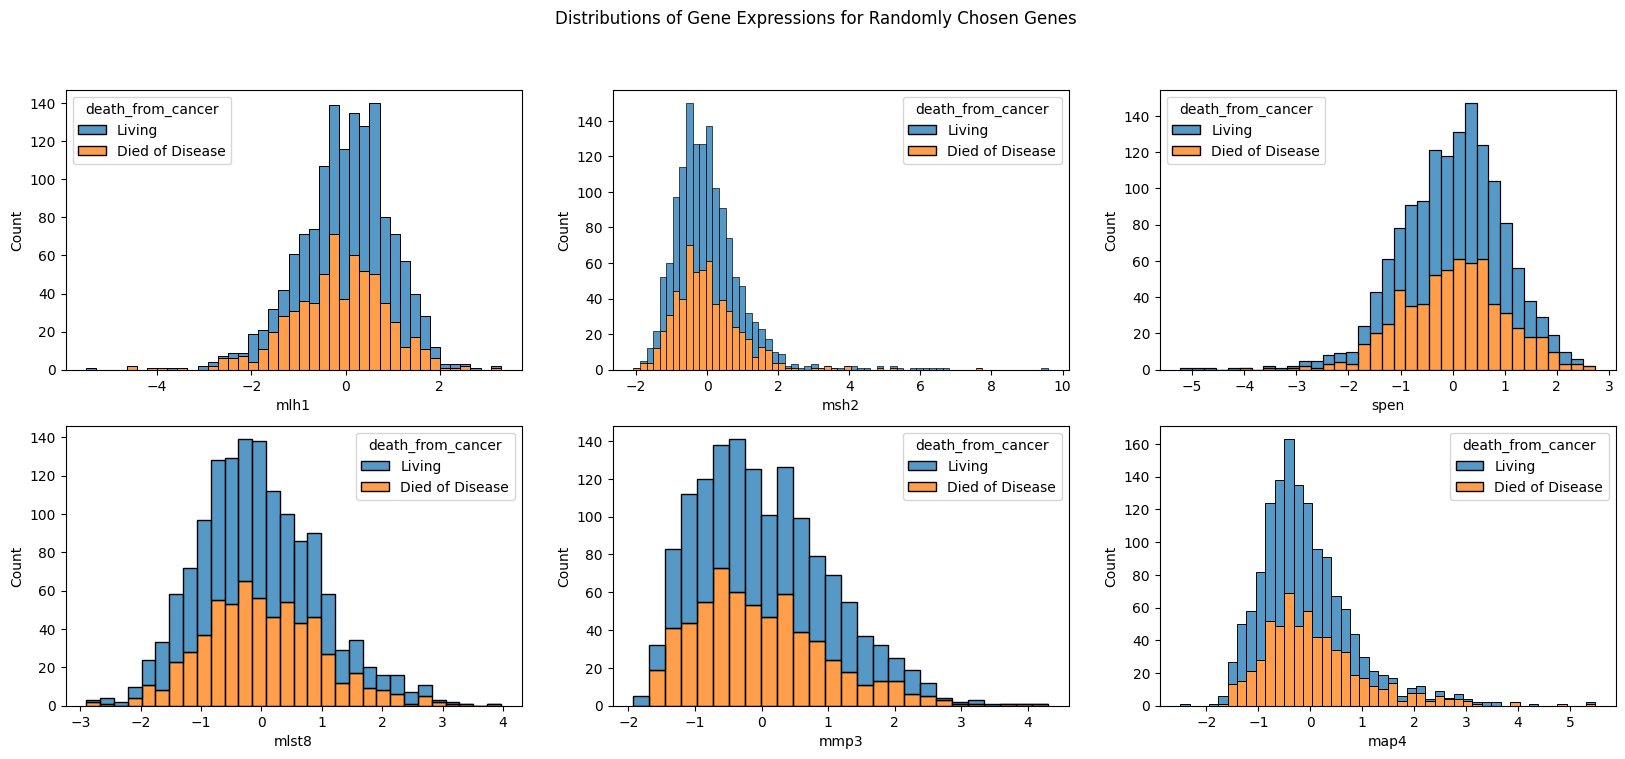

In [330]:
#now we can look at some distributions of gene expressions to get an idea of what those look like
#for the time frame of this project, I am choosing not to work with this data

#filter df to get rid of non cancer related deaths
data = data[data["death_from_cancer"]!="Died of Other Causes"]

#get some random gene expr columns 
gene_expr_cols = data.iloc[:, 27:(27+331)].columns.to_list()
ex1 = gene_expr_cols[10]
ex2 = gene_expr_cols[11]
ex3 = gene_expr_cols[100]
ex4 = gene_expr_cols[173]
ex4 = gene_expr_cols[201]
ex5 = gene_expr_cols[220]
ex6 = gene_expr_cols[299]

fig, axes = plt.subplots(2, 3, figsize=(20, 8))

#plots for some randomly chosen genes 
sns.histplot(data = data, x = ex1, hue = "death_from_cancer", ax = axes[0,0], multiple ="stack")
sns.histplot(data = data, x = ex2, hue = "death_from_cancer", ax = axes[0,1], multiple="stack")
sns.histplot(data = data, x = ex3, hue = "death_from_cancer", ax = axes[0,2], multiple = "stack")
sns.histplot(data = data, x = ex4, hue = "death_from_cancer", ax = axes[1,0], multiple = "stack")
sns.histplot(data = data, x = ex5, hue = "death_from_cancer", ax = axes[1,1], multiple = "stack")
sns.histplot(data = data, x = ex6, hue = "death_from_cancer", ax = axes[1,2], multiple = "stack")
fig.suptitle("Distributions of Gene Expressions for Randomly Chosen Genes")


Now I want to make sure the data is usable for models so I will fill in the missing values. 

In [331]:
#now we need to get rid of the Nan values before modelling. We will do this through imputation. 
from miceforest import ImputationKernel

clinical_data_encoded.reset_index(drop=True, inplace=True)
clinical_data.reset_index(drop=True, inplace=True)

mice_kernel = ImputationKernel(data = clinical_data_encoded, save_all_iterations_data= True)
mice_kernel.mice(5)
clinical_data_encoded = mice_kernel.complete_data()

In [332]:
clinical_data_encoded.head()

,patient_id,age_at_diagnosis,chemotherapy,cohort,er_status_measured_by_ihc,neoplasm_histologic_grade,her2_status,hormone_therapy,inferred_menopausal_state,lymph_nodes_examined_positive,...,integrative_cluster_3,integrative_cluster_4ER+,integrative_cluster_4ER-,integrative_cluster_5,integrative_cluster_6,integrative_cluster_7,integrative_cluster_8,integrative_cluster_9,primary_tumor_laterality_Left,primary_tumor_laterality_Right
0,0,75.65,False,1.0,False,3.0,False,True,True,10.0,...,False,True,False,False,False,False,False,False,False,True
1,2,43.19,False,1.0,False,3.0,False,True,False,0.0,...,False,True,False,False,False,False,False,False,False,True
2,5,48.87,True,1.0,False,2.0,False,True,False,1.0,...,True,False,False,False,False,False,False,False,False,True
3,6,47.68,True,1.0,False,2.0,False,True,False,3.0,...,False,False,False,False,False,False,False,True,False,True
4,8,76.97,True,1.0,False,3.0,False,True,True,8.0,...,False,False,False,False,False,False,False,True,False,True


# Part 2 - Models 

We now have have a cleaned data set that is one hot encoded, missing values are imputed, and we are ready to start modelling. 

At this point I am not sure if I have too many feautures. I thought about using PCA for feature reduction but I wanted to try out the models first to see how it goes. So I first experiment with running a logistic regression with the current data set. 

In [333]:
#make x and y 
X_clin = clinical_data_encoded.drop(["death_from_cancer", "patient_id"], axis =1)
y_clin = clinical_data["death_from_cancer"]

In [334]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clin, y_clin, test_size=0.2)

## Logistic Regression

In [335]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score

log_model = LogisticRegression(max_iter=10000).fit(X_train, y_train)
#accuracy score
log_score = log_model.score(X_test, y_test)

#precision score 
ypp = log_model.predict_proba(X_test)[:,1]
ypp = [1 if x>0.5 else 0 for x in ypp]
log_precision = precision_score(ypp, y_test)

#recall score
log_recall = recall_score(ypp, y_test)


print("Accuracy score for logistic regression model is", log_score)
print("Precision score for logistic regression model is", log_precision)
print("Recall score for logistic regression model is", log_recall)

Accuracy score for logistic regression model is 0.7929824561403509
Precision score for logistic regression model is 0.7560975609756098
Recall score for logistic regression model is 0.7622950819672131


At this point I did stop and think about using PCA for feature elimination and I played around with it a little (not shown here). I first scaled the data to normalize numeric columns and then looked a couple different number of components. I was getting results close to the accuracy listed above but not quite as good, so I ultimately decided not to include it. The main reasoning was that the logistic model was able to run in a few seconds using all the current features. I had to bump up the iterations but it did not slow the program down enough to justify needing feature reduction. And I wanted to see how the current dataset with all the features performs with later models. 

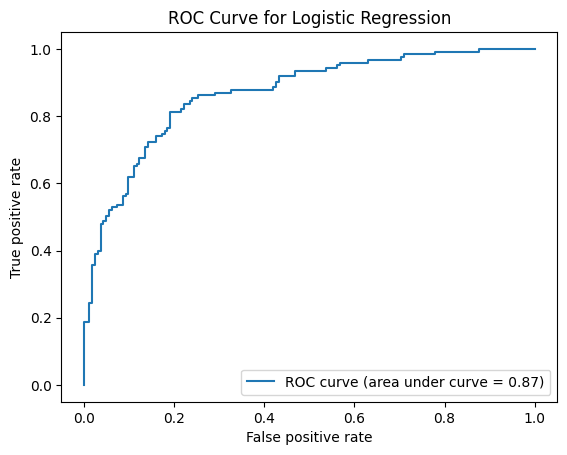

In [336]:
#ROC curve to see logistic regression model performance 
y_pred_log = log_model.predict_proba(X_test)

fpr, tpr, thr = roc_curve(y_test, y_pred_log[:,1])
roc_auc = roc_auc_score(y_test, y_pred_log[:,1])

plt.plot(fpr, tpr, label='ROC curve (area under curve = %0.2f)' % roc_auc)
plt.title("ROC Curve for Logistic Regression")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()

## Decision Tree

Now I am going to make a Decision Tree model. The Decision Tree can easily overfit data, so I will puse GridSearchCV to identify optimize the hyperparameters. I will use max_depth and min_samples_leaf as the hyperparameters to help avoid overfitting. 

In [337]:
#now let's try a Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#find best hyperparameters and build model based on those 
parameters = {"max_depth":[1,2,3,4,5,6,7,8,9,10], "min_samples_leaf":[1,2,34,5,6,7,8,9,10]}
dtree_model= GridSearchCV(DecisionTreeClassifier(), parameters).fit(X_train, y_train)
y_pred_dtree = dtree_model.predict(X_test)

#accuracy score
score_dtree = accuracy_score(y_pred=y_pred_dtree, y_true=y_test)

#precision score 
precision_dtree = precision_score(ypp, y_test)

#recall score
recall_dtree = recall_score(ypp, y_test)

print("Best hyperparameters are:", dtree_model.best_estimator_)
print("Accuracy score for Decision Tree model is", score_dtree)
print("Precision score for Decision Tree model is", precision_dtree)
print("Recall score for Decision Tree model is", recall_dtree)

Best hyperparameters are: DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)
Accuracy score for Decision Tree model is 0.8385964912280702
Precision score for Decision Tree model is 0.7560975609756098
Recall score for Decision Tree model is 0.7622950819672131


## Random Forest Classifier

This one started to take longer to run with the GridSearch but it was under a minute so I felt okay about that.

In [357]:
#random forest classifier 
from sklearn.ensemble import RandomForestClassifier

#I did some hand tuning to get an idea of the range for these numbers 
parameters = {"n_estimators":[20,40,60,80,90,100,110, 120], "max_depth":[1,2,3,4,5,6,7,8,9,10]}
rf_model = GridSearchCV(RandomForestClassifier(), parameters).fit(X_train, y_train)
y_pred_rf = best_model.predict(X_test)

#accuracy score 
score_rf = accuracy_score(y_test, y_pred_rf)

#precision score 
precision_rf = precision_score(ypp, y_test)

#recall score
recall_rf = recall_score(ypp, y_test)

print("Best hyperparameters are:", rf_model.best_estimator_)
print("Accuracy score for Random Forest model is", score_rf)
print("Precision score for Random Forest model is", precision_rf)
print("Recall score for Random Forest model is", recall_rf)

Best hyperparameters are: RandomForestClassifier(max_depth=9, n_estimators=80)
Accuracy score for Random Forest model is 0.8280701754385965
Precision score for Random Forest model is 0.7560975609756098
Recall score for Random Forest model is 0.7622950819672131


## K Nearest Neighbors 

For KNN, I play around with 3 hyperparameters:
- n_neighbors : how many neighbors surrounding the target are considered
- metric : whether distance in Euclidean or Manhattan
- weights : weighting neighbors based on distance from target

In [339]:
from sklearn.neighbors import KNeighborsClassifier

#smaller n_neighbors may lead to overfitting but if too high and it's not accurate enough
#metric is type of distance
#weights is whether neighbors treating differently (weighted) based on their distance from target
parameters = {"n_neighbors": [10,14,16,20,24,26,28,30,32,34,38],"metric": ['euclidean', 'manhattan'],"weights":['uniform','distance']}
model_n = GridSearchCV(KNeighborsClassifier(), parameters).fit(X_train, y_train)
y_pred_n = model_n.predict(X_test)

#accuracy score
score_n = accuracy_score(y_pred_n, y_test)

#precision score 
precision_n = precision_score(ypp, y_test)

#recall score
recall_n = recall_score(ypp, y_test)

print("Best hyperparameters are:", model_n.best_estimator_)
print("Accuracy score for KNN model is", score_n)
print("Precision score for KNN model is", precision_n)
print("Recall score for KNN model is", recall_n)

Best hyperparameters are: KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance')
Accuracy score for KNN model is 0.8315789473684211
Precision score for KNN model is 0.7560975609756098
Recall score for KNN model is 0.7622950819672131


## Gradient Boost

My first attempt at this one took just over 5 minutes to run. I wanted to see if I could get that time down so I use PCA to do a feature reduction. The goal is that having less features will lead to a faster runtime. 

After using PCA for feature reduction, the runtime decreased to about 30 seconds.

In [340]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#data has a lot of categorical features so I want to make sure I'm just scaling the numerical features. 
nums = X_clin.select_dtypes(include ="number")
nums = nums.columns.to_list()
#apply scaling to numerical features 
scaled = scaler.fit_transform(X_clin[nums])
X_clin[nums] = scaled

In [353]:
#now that our data is scaled we can do feature selection with PCA 
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
#fit on trainign data and then apply transform to both 
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#variance explained by each component 
explained_variance = pca.explained_variance_ratio_  
print("Explained variance ratio:\n", explained_variance.sum())


Explained variance ratio:
 0.9987879844445038


In [351]:
from sklearn.ensemble import GradientBoostingClassifier

#again, I got these ranges from hand tuning experiements 
parameters={"learning_rate": [0.01, 0.05, 0.1,0.3], "n_estimators":[90, 120, 140, 180, 210, 240]}
gb_model=GridSearchCV(GradientBoostingClassifier(), parameters).fit(X_train_pca, y_train)
y_pred_gb = gb_model.predict(X_test_pca)

#accuracy score
score_gb = accuracy_score(y_pred_gb, y_test)

#precision score 
precision_gb = precision_score(y_pred_gb, y_test)

#recall score
recall_gb = recall_score(y_pred_gb, y_test)

print("Best hyperparameters are:", gb_model.best_estimator_)
print("Accuracy score for GradientBoost model is", score_gb)
print("Precision score for GradientBoost model is", precision_gb)
print("Recall score for GradientBoost model is", recall_gb)

Best hyperparameters are: GradientBoostingClassifier(learning_rate=0.01, n_estimators=210)
Accuracy score for GradientBoost model is 0.8105263157894737
Precision score for GradientBoost model is 0.7317073170731707
Recall score for GradientBoost model is 0.8108108108108109


## Outcome 

Now let's compare performance across the models. 

C:\Users\Nicole\AppData\Local\Temp\ipykernel_18988\3581659215.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Nicole\AppData\Local\Temp\ipykernel_18988\3581659215.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Nicole\AppData\Local\Temp\ipykernel_18988\3581659215.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


Text(0.5, 1.0, 'Precision Score')

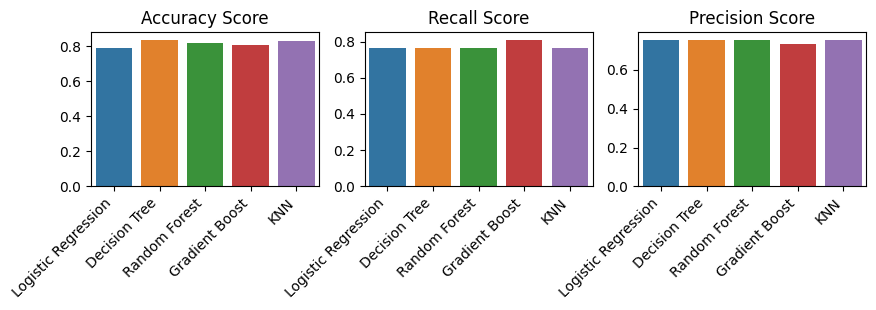

In [352]:
#make histogram tc compare accuracy of all models 

scores_x = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boost", "KNN"]
scores_y = [log_score, score_dtree, score_rf, score_gb, score_n]
recall_y = [log_recall, recall_dtree, recall_rf, recall_gb, recall_n]
precision_y = [log_precision, precision_dtree, precision_rf, precision_gb, precision_n]

fig, axes = plt.subplots(1,3, figsize = (10,2))
sns.barplot(x=scores_x, y=scores_y, hue=scores_x, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("Accuracy Score")

sns.barplot(x=scores_x, y=recall_y, hue=scores_x, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("Recall Score")


sns.barplot(x=scores_x, y=precision_y, hue=scores_x, ax=axes[2])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_title("Precision Score")


Discussion of model performance - 

The figures above show the performance metrics of the various models tested here. The accuracy scores all hover around 0.8 percent, with Decision Tree and KNN taking the lead just slightly. 

For recall scores, GradientBoost is the leader at 0.81. This is a good example of the trade off between recall and precision because we see that GradientBoost falls just slightly short for precision. We have to consider the circumstances of the classification problem - predicting survival from cancer. High recall means that the model is more likely to successfully identify positive cases. High precision means that when the model makes a positive prediction, it is more likely to be right in that prediction. Given that we are predicting death from cancer, we are interested in having high recall. If a person is likely to succumb to the disease, we want to be able to make that prediction and take appropriate action. It would be unfortunate to miss a diagnosis and tell a patient they are likely to live when that is not the case. 

Looking at these final metrics, I would say that Gradient Boost is the most preferrable of these models. The differences in accuracy are so minimal that I think the benefit gained from the increased recall is worthwhile.

In [367]:
#now let's look at most important features from a tree models because they're easiest to find

#feature names 
names = X_train.columns.to_list()

#features from random forest 
best_model_rf = rf_model.best_estimator_
importances_rf = best_model_rf.feature_importances_
feature_importance_rf = sorted(zip(importances_rf, names), reverse=True)
print("Most important features from Random Forest: \n", feature_importance_rf)

#features from decision tree 
best_model_dt = dtree_model.best_estimator_
importances_dt = best_model_dt.feature_importances_
feature_importance_dt = sorted(zip(importances_dt, names), reverse=True)
print("Most important features from Decision Tree: \n", feature_importance_dt)


Most important features from Random Forest: 
 [(0.30163218870255404, 'overall_survival_months'), (0.0859429412280536, 'age_at_diagnosis'), (0.08490605196995438, 'nottingham_prognostic_index'), (0.06811111141043671, 'tumor_size'), (0.05571503476715596, 'lymph_nodes_examined_positive'), (0.04558794291616294, 'cohort'), (0.042187115209589156, 'mutation_count'), (0.01580497164056976, 'pam50_+_claudin-low_subtype_LumA'), (0.015608668747668572, 'neoplasm_histologic_grade'), (0.013620350578607632, 'type_of_breast_surgery_MASTECTOMY'), (0.012780267725109696, 'pam50_+_claudin-low_subtype_LumB'), (0.011496768394391678, 'type_of_breast_surgery_BREAST CONSERVING'), (0.01144719834829387, 'primary_tumor_laterality_Left'), (0.011200067352076123, 'cellularity_High'), (0.01092383559112414, 'pr_status'), (0.009699063570091346, 'primary_tumor_laterality_Right'), (0.009555898243668048, 'radio_therapy'), (0.009365153696911694, 'integrative_cluster_5'), (0.009287689416379568, 'hormone_therapy'), (0.00828925

**What features are most influential in predicting death from breast cancer?**

I extracted most important features from Random Forest and Decision Tree to get an idea of the most important features in this data set. I was not suprised that overall_survival_months was the top feature for both. I had originally thought about taking this out because it is somewhat redundant to death_from_cancer. But when I thought about it more, the longer a person survives might mean they are more likely to survive and that felt important. For example, if a patient comes in at 0 months and gets diagnosed with "likely to die" and then comes back at 10 months still alive, that might mean their diagnosis could change. This could be something that requires deeper domain knowledge. 

The next feature that was in the top 3 of both models was the nottingham_prognostic_index. This also makes sense considering the feature defintion: "It is used to determine prognosis following surgery for breast cancer. Its value is calculated using three pathological criteria: the size of the tumour; the number of involved lymph nodes; and the grade of the tumour.". These are all highly influential factors so combined it makes sense it is an important indicator. 

Age is also included as a top feature in both these models, which also makes sense. 

# Summary:

**Models**<br>
To classify survival from breast cancer, I explored the following models:
- Logistic Regression 
- Decision Tree Classifier
- Random Forest Classifier
- Gradient Boost Classifier 

I chose these models because I wanted to play around with a variety of tree-based models (and I threw in the logistic regression for the sake of comparison). The Decision Tree is the basic tree model, while random forest is a parallel ensemble method and Gradient Boost is a sequential ensemble method. (Ensemble describing how the trees are assmebled before resulting in the final tree). These models are all suitable for datasets with complex features including numerical and categorical. 

All the models except Gradient Boost were able to run in a reasonable amount of time without feature reduction. For gradient boost, I used PCA to reduce features. I chose the number of components based on the amount of variance they captured. I also made sure to train the PCA on the train data and then apply it to transform the test and train data. The reduced number of components allowed Gradient Boost to reduce runtime down to about 30 seconds. I also saw an increase in recall (not shown above) from the pre-PCA Gradient Boost to the post-PCA Gradient Boost. 

Finally, I used GridSearchCV to optimize the hyperparameters for each model. I did some initial hand-tuning to identify hyperparameters and relative ranges that I input into GridSearchCV. The optimized results were slightly better performing models than my hand-tuned models and much more efficient so that was great. 

**Learning Outcomes**<br>
Overall, this was a great exercise in comparing different supervised learning modules (especially run time) and learning to fine tune the hyperparameters. I also tried PCA for the first time and learned a lot about the preprocessing steps (impute, normalize, split), how to implement, and when to implement. Another big learning curve was the data cleaning and exploration. There were a lot of redundant features in this data set that had to be sorted through. I mentioned most of my logic above, but in general to solve this I kept the features with the most detail and the least number of missing values.

*Note - I realized about halfway through this project that one homework assignment already used breast cancer data, but I do feel like this was very different. There was so much cleaning and feature consideration in this dataset that I still felt like this was a challenge and different enough to continue using this data.*